In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 92602219.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23453183.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27384246.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21526021.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

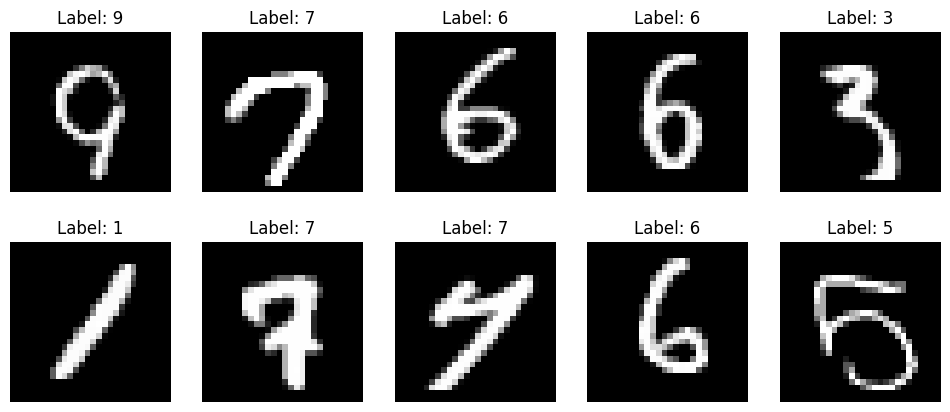

In [7]:
def plot_sample_images(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images.numpy()
    labels = labels.numpy()

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.show()

plot_sample_images(train_loader)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.L1 = nn.Linear(28*28, 128)
        self.L2 = nn.Linear(128, 64)
        self.L3 = nn.Linear(64, 10)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.L3(self.R(self.L2(self.R(self.L1(x)))))

In [9]:
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_loss = running_test_loss / len(test_loader)

    test_loss_list.append(test_loss)
    test_acc_list.append(test_accuracy)

    print(f"Accuracy on test data: {test_accuracy:.2f}%")

Epoch [1/10], Loss: 0.3883, Accuracy: 88.57%
Accuracy on test data: 93.49%
Epoch [2/10], Loss: 0.1856, Accuracy: 94.42%
Accuracy on test data: 96.09%
Epoch [3/10], Loss: 0.1348, Accuracy: 95.76%
Accuracy on test data: 96.22%
Epoch [4/10], Loss: 0.1057, Accuracy: 96.75%
Accuracy on test data: 96.65%
Epoch [5/10], Loss: 0.0918, Accuracy: 97.15%
Accuracy on test data: 96.94%
Epoch [6/10], Loss: 0.0819, Accuracy: 97.35%
Accuracy on test data: 97.23%
Epoch [7/10], Loss: 0.0732, Accuracy: 97.66%
Accuracy on test data: 97.27%
Epoch [8/10], Loss: 0.0639, Accuracy: 97.93%
Accuracy on test data: 97.36%
Epoch [9/10], Loss: 0.0595, Accuracy: 98.09%
Accuracy on test data: 97.31%
Epoch [10/10], Loss: 0.0558, Accuracy: 98.14%
Accuracy on test data: 97.30%


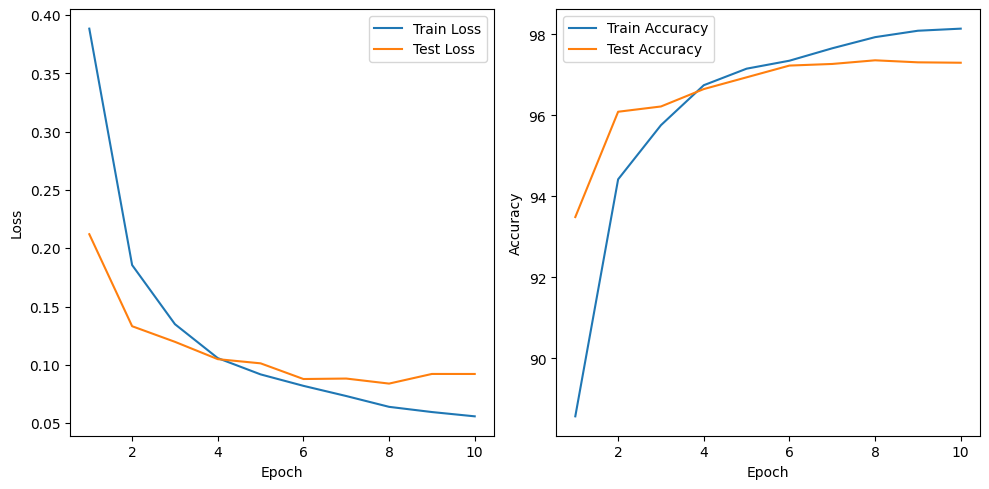

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[64, 1, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 10]                  --
├─Linear: 1-1                            [64, 128]                 100,480
├─ReLU: 1-2                              [64, 128]                 --
├─Linear: 1-3                            [64, 64]                  8,256
├─ReLU: 1-4                              [64, 64]                  --
├─Linear: 1-5                            [64, 10]                  650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 7.00
Input size (MB): 0.20
Forward/backward pass size (MB): 0.10
Params size (MB): 0.44
Estimated Total Size (MB): 0.74

In [37]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [38]:
model1 = Net1().to(device)

criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

In [39]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

In [40]:
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = model1(images)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    model1.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            test_loss = criterion1(outputs, labels)
            running_test_loss += test_loss.item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_loss = running_test_loss / len(test_loader)

    test_loss_list.append(test_loss)
    test_acc_list.append(test_accuracy)

    print(f"Accuracy on test data: {test_accuracy:.2f}%")

Epoch [1/10], Loss: 0.5510, Accuracy: 82.91%
Accuracy on test data: 93.83%
Epoch [2/10], Loss: 0.2871, Accuracy: 91.80%
Accuracy on test data: 95.08%
Epoch [3/10], Loss: 0.2387, Accuracy: 93.09%
Accuracy on test data: 95.49%
Epoch [4/10], Loss: 0.2134, Accuracy: 93.78%
Accuracy on test data: 96.12%
Epoch [5/10], Loss: 0.1952, Accuracy: 94.32%
Accuracy on test data: 96.05%
Epoch [6/10], Loss: 0.1817, Accuracy: 94.78%
Accuracy on test data: 96.37%
Epoch [7/10], Loss: 0.1762, Accuracy: 94.83%
Accuracy on test data: 96.57%
Epoch [8/10], Loss: 0.1714, Accuracy: 95.02%
Accuracy on test data: 96.88%
Epoch [9/10], Loss: 0.1626, Accuracy: 95.29%
Accuracy on test data: 96.63%
Epoch [10/10], Loss: 0.1553, Accuracy: 95.45%
Accuracy on test data: 96.91%


In [41]:
summary(model1, input_size=[64, 1, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
Net1                                     [64, 10]                  --
├─Linear: 1-1                            [64, 256]                 200,960
├─ReLU: 1-2                              [64, 256]                 --
├─Dropout: 1-3                           [64, 256]                 --
├─Linear: 1-4                            [64, 128]                 32,896
├─ReLU: 1-5                              [64, 128]                 --
├─Dropout: 1-6                           [64, 128]                 --
├─Linear: 1-7                            [64, 64]                  8,256
├─ReLU: 1-8                              [64, 64]                  --
├─Dropout: 1-9                           [64, 64]                  --
├─Linear: 1-10                           [64, 10]                  650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
Total mult-adds (M): 15.54
Input size (MB): 0.20
Forward/backward pass

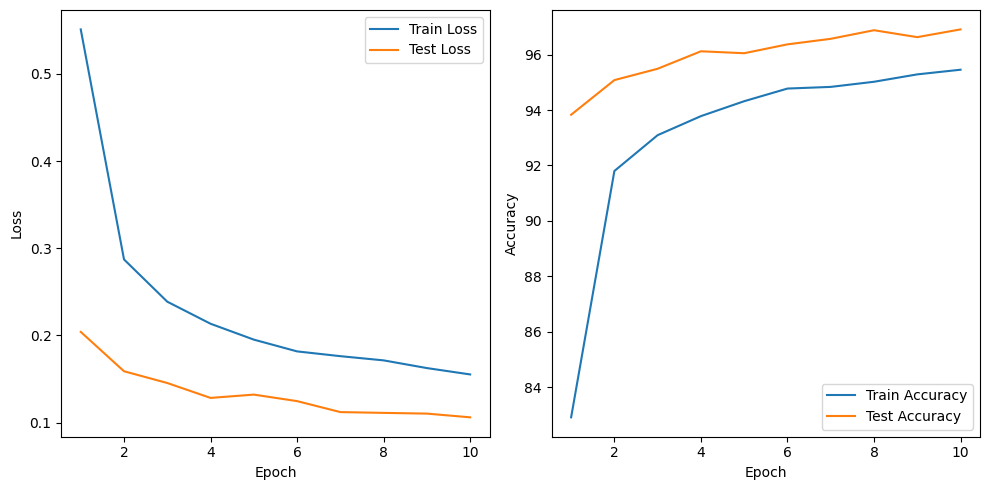

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = model1(images)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    model1.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            test_loss = criterion1(outputs, labels)
            running_test_loss += test_loss.item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_loss = running_test_loss / len(test_loader)

    test_loss_list.append(test_loss)
    test_acc_list.append(test_accuracy)

    print(f"Accuracy on test data: {test_accuracy:.2f}%")

Epoch [1/10], Loss: 0.1490, Accuracy: 95.67%
Accuracy on test data: 97.57%
Epoch [2/10], Loss: 0.1467, Accuracy: 95.65%
Accuracy on test data: 97.43%
Epoch [3/10], Loss: 0.1426, Accuracy: 95.78%
Accuracy on test data: 97.45%
Epoch [4/10], Loss: 0.1421, Accuracy: 95.85%
Accuracy on test data: 97.19%
Epoch [5/10], Loss: 0.1364, Accuracy: 96.04%
Accuracy on test data: 97.62%
Epoch [6/10], Loss: 0.1327, Accuracy: 96.09%
Accuracy on test data: 97.55%
Epoch [7/10], Loss: 0.1325, Accuracy: 96.05%
Accuracy on test data: 97.72%
Epoch [8/10], Loss: 0.1268, Accuracy: 96.27%
Accuracy on test data: 97.72%
Epoch [9/10], Loss: 0.1268, Accuracy: 96.33%
Accuracy on test data: 97.24%
Epoch [10/10], Loss: 0.1277, Accuracy: 96.20%
Accuracy on test data: 97.48%


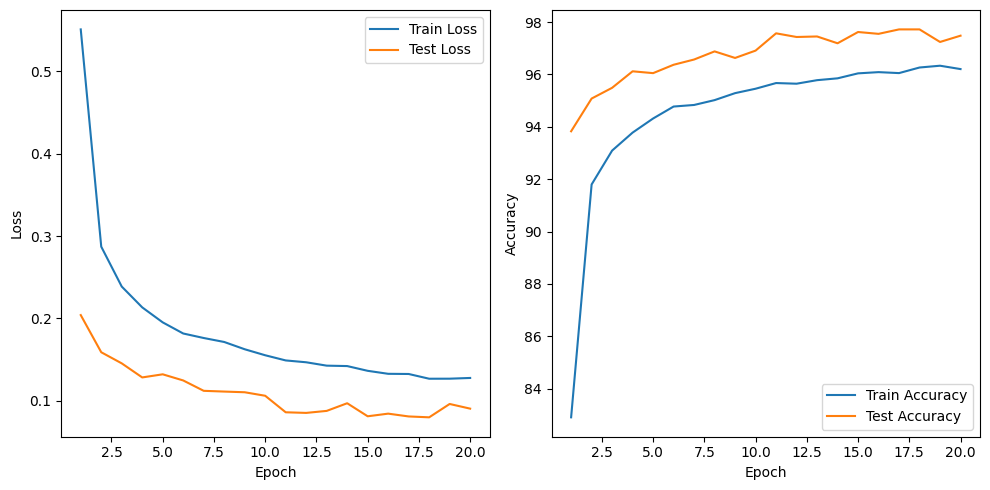

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 2*num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, 2*num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, 2*num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, 2*num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()